# Abnormal detection of Chip Temperature Time Series

In [1]:
import os
import numpy as np
import keras
import pickle
import pandas as pd
from keras.utils import plot_model
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


# 1. Pre-processing chip temperature data

In [2]:
# Step 1. Read chip temperature data from CSV file
temp_base_data = pd.read_csv('data/temp_data.csv')
print(temp_base_data.shape)

(8000, 643)


In [3]:
# Step 2. Divide data into time series data based on burn-in board coordinates
temp_data = temp_base_data.pivot(index='ID', columns='Time(min)')
print(temp_data.shape)

# Rename column name as string value
data_cols = list(temp_data.columns)
print(data_cols[0:1])
cols_name_list = ['{0}_{1}'.format(col_item[0], col_item[1]) for col_item in data_cols]
print(cols_name_list[0:1])
    
temp_data.columns = cols_name_list
print(temp_data.head(n=2))

(400, 12820)
[('(0,0)', 0)]
['(0,0)_0']
      (0,0)_0    (0,0)_1    (0,0)_2    (0,0)_3    (0,0)_4    (0,0)_5  \
ID                                                                     
0   88.163629  88.199156  88.195955  88.306668  88.494888  88.772998   
1   88.220006  88.149313  88.400012  88.268553  88.408342  88.533569   

      (0,0)_6    (0,0)_7    (0,0)_8    (0,0)_9  ...  OvenTemp_10  OvenTemp_11  \
ID                                              ...                             
0   88.544367  88.787529  90.243504  92.257389  ...    88.757193    88.676110   
1   88.859991  88.523043  88.739705  88.855851  ...    88.936333    88.739476   

    OvenTemp_12  OvenTemp_13  OvenTemp_14  OvenTemp_15  OvenTemp_16  \
ID                                                                    
0     89.146079    89.014041    89.234827    88.789451    89.529940   
1     89.196844    89.303090    88.827092    88.773277    89.022037   

    OvenTemp_17  OvenTemp_18  OvenTemp_19  
ID               

In [4]:
# Step 3. Check Null value

null_value_sum = temp_data.isnull().sum().sum()
print('Total null value in dataset: ', null_value_sum)

Total null value in dataset:  0


In [5]:
# Step 3. Divide data into trainng set and testing set
data_train, data_test = train_test_split(temp_data, test_size=0.20, random_state=49)
print("Training data: ", data_train.shape)
print("Testing data: ", data_test.shape)

Training data:  (320, 12820)
Testing data:  (80, 12820)


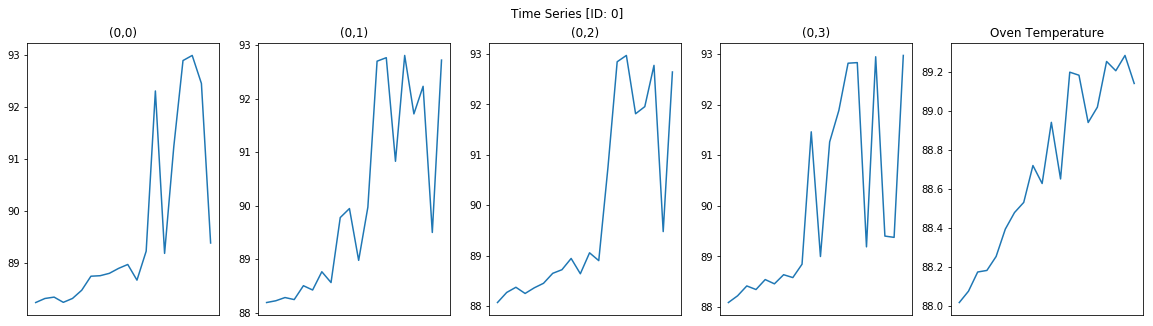

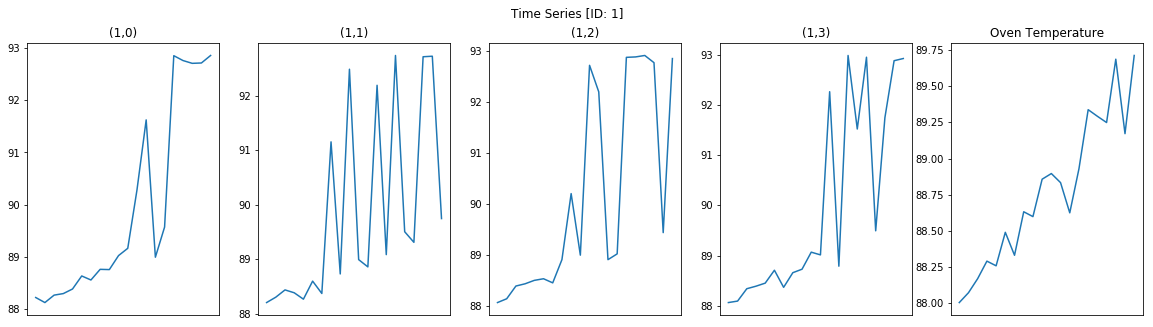

In [51]:
# Step 4. Check temperature time series
def draw_time_series(df_data, index_start, length):
    oven_cols_index = df_data.shape[1] - 20
    n_parts = 5
    for i in range(index_start, index_start + length):
        fig, axes = plt.subplots(1, n_parts, figsize=(20, 5))
        data_title = 'Time Series [ID: {0}]'.format(i)
        fig.suptitle(data_title, fontsize=12)
            
        for j in range(n_parts):
            if j == n_parts - 1:
                # Oven temperature
                data_series = df_data.iloc[i, oven_cols_index:oven_cols_index+20]
                axes[j].set_title('Oven Temperature')
            else:
                data_series = df_data.iloc[i, j*20:(j+1)*20]
                axes[j].set_title('({0},{1})'.format(i, j))
                
            axes[j].get_xaxis().set_visible(False)
            axes[j].plot(data_series)

    plt.show()
    
draw_time_series(data_train, 0, 2)

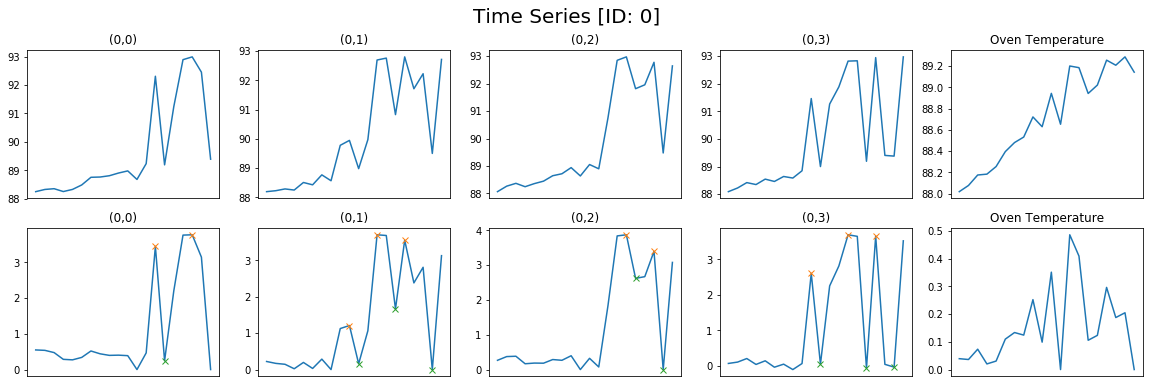

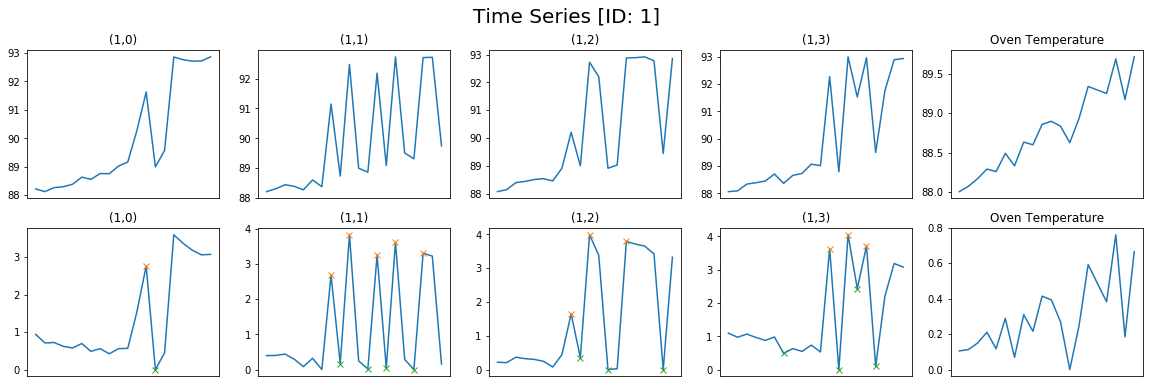

In [57]:
# Step 5. Perform Baseline Correction and Locate peaks and trough
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks as findPeaks

def alsbase(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    
    return z

def corr_baseline(y):
    y_base = alsbase(y, 10^5,0.000005,niter=50)
    corr_y = y - y_base
    return corr_y

def find_series_peaks(df_data, index_start, length, prominance, distance):
    oven_cols_index = df_data.shape[1] - 20
    n_parts = 5
    for i in range(index_start, index_start + length):
        fig, axes = plt.subplots(2, n_parts, figsize=(20, 6))
        data_title = 'Time Series [ID: {0}]'.format(i)
        fig.suptitle(data_title, fontsize=20)
        
        for j in range(n_parts):
            if j == n_parts - 1:
                # Oven temperature
                data_series = df_data.iloc[i, oven_cols_index:oven_cols_index+20]
                axes[0, j].set_title('Oven Temperature')
            else:
                data_series = df_data.iloc[i, j*20:(j+1)*20]
                axes[0, j].set_title('({0},{1})'.format(i, j))
                
            axes[0, j].get_xaxis().set_visible(False)
            axes[0, j].plot(data_series)
        
        for j in range(n_parts):
            if j == n_parts - 1:
                # Oven temperature
                data_series = df_data.iloc[i, oven_cols_index:oven_cols_index+20]
                axes[1, j].set_title('Oven Temperature')
            else:
                data_series = df_data.iloc[i, j*20:(j+1)*20]
                axes[1, j].set_title('({0},{1})'.format(i, j))
            
            axes[1, j].get_xaxis().set_visible(False)
            
            corr_n = corr_baseline(data_series)
            # Locate peaks
            (pks_n, _) = findPeaks(corr_n, prominence=prominance, distance=distance)
            axes[1, j].plot(corr_n)
            axes[1, j].plot(pks_n, corr_n[pks_n],'x')
            # Locate trough
            (pks_n, _) = findPeaks(corr_n * (-1), prominence=prominance, distance=distance)
            #axes[j].plot(data_series)
            axes[1, j].plot(pks_n, corr_n[pks_n],'x')
            

    plt.show()
   
find_series_peaks(data_train, 0, 2, 0.6, 2)

In [45]:
# Configuration on autoencoder model

# Dimension of input signal, determined by your test data
signal_dimension = 784 

# Dimension of encoded features, can be adjusted by user
encoder_dimension = 2

# training setup
EPOCHS = 5
BATCH_SIZE = 64


In [25]:
# Define an autoencoder model using Sequential method

def AE_method1(x_train):
    FINAL_DIM = 900
    data_dim = data_train.shape[1]
    print('data_dim: ', data_dim)
    autoencoder = Sequential()
    autoencoder.add(Dense(encoder_dimension, activation='relu', input_shape=(signal_dimension, ), name='layer1'))
    autoencoder.add(Dense(signal_dimension, activation='relu',name='layer2'))
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)
    
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('layer1').output)
    return encoder, autoencoder


In [26]:
# Show the encoding coefficients

def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    #print('len(inputs): ', n)
    fig, axes = plt.subplots(2, n)
    for i in range(n):
        print(i, '-th image, encoding coefficients are ', latent_repr[i,:])
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


(60000, 28, 28) (10000, 28, 28)


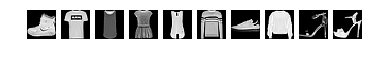

(60000, 784) (10000, 784)


In [27]:
# For the first time of running this code, it will automatically download fashion_mnist data from Internet
# Load data
(data_train, label_train), (data_test, label_test) = fashion_mnist.load_data()
print(data_train.shape, data_test.shape)

# Normalize
data_train = data_train.astype('float32') / 255.
data_test = data_test.astype('float32') / 255.

# Plot the examples of original images
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(data_train[i], cmap='gray')
    ax[i].axis('off')

plt.show()

data_train = data_train.reshape((data_train.shape[0], -1))
data_test = data_test.reshape((data_test.shape[0], -1))
print(data_train.shape, data_test.shape)


In [28]:
# Demo autoencoder using method 1 (Sequential method)

model_encoder, model_autoencoder = AE_method1(x_train=data_train)
model_encoder.summary()
model_autoencoder.summary()


data_dim:  784
Epoch 1/5
60000/60000 [==============================] - 2s 36us/step - loss: 0.0947
Epoch 2/5
60000/60000 [==============================] - 2s 28us/step - loss: 0.0867
Epoch 3/5
60000/60000 [==============================] - 2s 27us/step - loss: 0.0866
Epoch 4/5
60000/60000 [==============================] - 2s 27us/step - loss: 0.0866
Epoch 5/5
60000/60000 [==============================] - 2s 28us/step - loss: 0.0865
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_input (InputLayer)    (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 2)                 1570      
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 O

0 -th image, encoding coefficients are  [3.4188435 0.       ]
1 -th image, encoding coefficients are  [10.86355   5.333355]
2 -th image, encoding coefficients are  [0.902102 9.501332]
3 -th image, encoding coefficients are  [0.       7.435261]
4 -th image, encoding coefficients are  [6.2173867 3.8457801]
5 -th image, encoding coefficients are  [2.7306008 7.6864796]


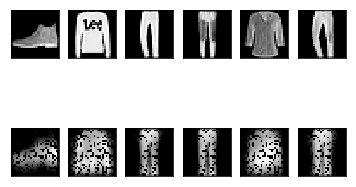

In [29]:
# Visualize the results and encoding coefficients

num_sample = 6 # Number of test samples used for visualization
data_encode = model_encoder.predict(data_test[:num_sample])

data_rec = model_autoencoder.predict(data_test)
show_encodings(data_test[:num_sample], data_encode, data_rec)


In [30]:
# Define an autoencoder model using Functional method

def AE_method2(x_train):
    # input placeholder
    input_image = Input(shape=(signal_dimension, ))

    # encoding layer
    hidden_layer = Dense(encoder_dimension, activation='relu')(input_image)

    # decoding layer
    decode_output = Dense(signal_dimension, activation='relu')(hidden_layer)

    # build autoencoder, encoder, decoder
    encoder = Model(inputs=input_image, outputs=hidden_layer)
    autoencoder = Model(inputs=input_image, outputs=decode_output)

    # compile autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')

    # training
    autoencoder.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

    return encoder, autoencoder


$\color{red}{\text{Q1. Complete the code to build autoencoder model and visualize the encoding coefficients.}}$

Tasks
- Build an autoencoder model using AE_method2()
- Plot the model summary
- Perform prediction using the first 5 test samples
- Visualize the original sample, encoding coefficients, reconstructed sample


In [31]:
# Provide your code to Q1 here
# Create and train autoencoder using method 2 (functional method)

# Build an autoencoder model using AE_method2()
model_encoder2, model_autoencoder2 = AE_method2(x_train=data_train)

# Plot the model summary
model_encoder2.summary()
model_autoencoder2.summary()



Epoch 1/5
60000/60000 [==============================] - 2s 32us/step - loss: 0.0964
Epoch 2/5
60000/60000 [==============================] - 2s 27us/step - loss: 0.0890
Epoch 3/5
60000/60000 [==============================] - 2s 27us/step - loss: 0.0888
Epoch 4/5
60000/60000 [==============================] - 2s 27us/step - loss: 0.0888
Epoch 5/5
60000/60000 [==============================] - 2s 27us/step - loss: 0.0887
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1570      
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape    

0 -th image, encoding coefficients are  [0.2259796 3.3950582]
1 -th image, encoding coefficients are  [ 6.366255 11.220873]
2 -th image, encoding coefficients are  [9.519173   0.88268083]
3 -th image, encoding coefficients are  [7.6491013 0.       ]
4 -th image, encoding coefficients are  [4.3444576 6.2234163]


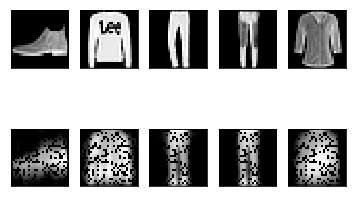

In [32]:
# Perform prediction using the first 5 test samples
num_sample2 = 5 # Number of test samples used for visualization
data_encode2 = model_encoder2.predict(data_test[:num_sample2])

data_rec2 = model_autoencoder2.predict(data_test)

# Visualize the original sample, encoding coefficients, reconstructed sample
show_encodings(data_test[:num_sample2], data_encode2, data_rec2)

# Exercise 2: Machine health monitoring

Reference: R. Zhao, R. Yan, Z. Chen, K. Mao, P. Wang, R. Gao, Deep learning and its applications to machine health monitoring, Mechanical Systems and Signal Processing, Vol. 115, Jan. 2019, pp. 213-237.
- pdf paper, https://arxiv.org/abs/1612.07640
- code, https://github.com/ClockworkBunny/MHMS_DEEPLEARNING

In [33]:
# Configuration
encoder_dimension = 10
NUM_EPOCH = 10
BATH_SIZE = 24


In [34]:
# Define an autoencoder model using Sequantial method

def build_AE_machine(data_train):
    data_dim = data_train.shape[1]
    ae = Sequential()
    ae.add(Dense(encoder_dimension, activation='relu', input_shape=(data_dim, )))
    ae.add(Dense(encoder_dimension, activation='relu'))
    ae.add(Dense(data_dim, activation='relu'))
    ae.compile(optimizer='adam', loss='mse')
    ae.fit(data_train, data_train, epochs=NUM_EPOCH, batch_size=BATH_SIZE, shuffle=True)
    
    return ae


In [35]:
# Load data 
x_train_pd = pd.read_csv("data/machine_sensor_train.csv",header=None)
x_train = x_train_pd.values
x_test_pd = pd.read_csv("data/machine_sensor_test.csv",header=None)
x_test = x_test_pd.values

# Train the model
normal_AE = build_AE_machine(x_train)
normal_AE.summary()


Epoch 1/10
600/600 [==============================] - 1s 1ms/step - loss: 0.4734
Epoch 2/10
600/600 [==============================] - 0s 90us/step - loss: 0.4512
Epoch 3/10
600/600 [==============================] - 0s 83us/step - loss: 0.4508
Epoch 4/10
600/600 [==============================] - 0s 85us/step - loss: 0.4506
Epoch 5/10
600/600 [==============================] - 0s 85us/step - loss: 0.4505
Epoch 6/10
600/600 [==============================] - 0s 86us/step - loss: 0.4504
Epoch 7/10
600/600 [==============================] - 0s 81us/step - loss: 0.4503
Epoch 8/10
600/600 [==============================] - 0s 85us/step - loss: 0.4502
Epoch 9/10
600/600 [==============================] - 0s 83us/step - loss: 0.4502
Epoch 10/10
600/600 [==============================] - 0s 85us/step - loss: 0.4501
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)         

In [36]:
sample_index = 0
thre = 10 # A manually-defined threshold

# Step 1: Select the test sample (such as the 0-th sample)
test_data_orig = x_test[sample_index:sample_index+1,:]
print(test_data_orig.shape)

# Step 2: Perform prediction using the trained autoencoder model
test_data_predict = normal_AE.predict(test_data_orig)

# Step 3: Calculate the reconstruction error and make decision on anomaly detection
dist = np.linalg.norm(test_data_orig - test_data_predict, axis=-1)

if (dist>thre):
    print('Anomaly detected: the distance is %.2f' % dist)
else:
    print('Normal: the distance is %.2f' % dist)
    

(1, 70)
Normal: the distance is 6.73


$\color{red}{\text{Q2. Complete the code to build autoencoder model for abnormal machine sensory signal detection.}}$

Tasks
- Build an autoencoder model using build_AE_machine()
- Peform the test on x_test and determine the test data (row index) with LARGEST reconstruction error based on your trained model


In [60]:
# Provide your code to Q2 here

# Build an autoencoder model (you can tune model configuration such as encoder_dimension)
encoder_dimension = 2
abnormal_threshold = 10

def build_AE_machine(data_train):
    data_dim = data_train.shape[1]
    
    # input placeholder
    input_data = Input(shape=(data_dim, ))

    # encoding layer
    hidden_layer1 = Dense(encoder_dimension, activation='relu', name='layer1')(input_data)

    hidden_layer2 = Dense(encoder_dimension, activation='relu', name='layer2')(hidden_layer1)
    
    # decoding layer
    decode_output = Dense(data_dim, activation='relu')(hidden_layer2)

    # build autoencoder
    autoencoder = Model(inputs=input_data, outputs=decode_output)

    # compile autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')

    # training
    autoencoder.fit(data_train, data_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)
    
    return autoencoder


# Perform prediction using the trained autoencoder model
def compute_dist(data_in, autoencoder_in, threshold=10):
    print(data_in.shape)

    data_dist = []
    
    for i in range(len(data_in)):
        # Step 1: Select the test sample (such as the 0-th sample)
        test_data_orig = data_in[i:i+1,:]
        
        # Step 2: Perform prediction using the trained autoencoder model
        test_data_predict = autoencoder_in.predict(test_data_orig)

        # Step 3: Calculate the reconstruction error and make decision on anomaly detection
        dist = np.linalg.norm(test_data_orig - test_data_predict, axis=-1)
        data_dist.append(dist)
        
        if dist > threshold:
            print('Anomaly detected (distance: %.2f)' % dist)
        else:
            print('Normal (distance: %.2f)' % dist)
        
    return np.array(data_dist)


# Train the model
normal_AE = build_AE_machine(x_train)
normal_AE.summary()

Epoch 1/5
600/600 [==============================] - 1s 840us/step - loss: 0.4607
Epoch 2/5
600/600 [==============================] - 0s 48us/step - loss: 0.4518
Epoch 3/5
600/600 [==============================] - 0s 45us/step - loss: 0.4513
Epoch 4/5
600/600 [==============================] - 0s 42us/step - loss: 0.4512
Epoch 5/5
600/600 [==============================] - 0s 42us/step - loss: 0.4512
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 70)                0         
_________________________________________________________________
layer1 (Dense)               (None, 2)                 142       
_________________________________________________________________
layer2 (Dense)               (None, 2)                 6         
_________________________________________________________________
dense_16 (Dense)             (None, 70)                210       


In [61]:
# Calculate the reconstruction error and make decision on anomaly detection
data_dist = compute_dist(x_test, normal_AE, threshold=abnormal_threshold)
print('data_dist: ', data_dist.shape)

(300, 70)
Normal (distance: 6.72)
Normal (distance: 6.83)
Normal (distance: 6.73)
Normal (distance: 6.62)
Normal (distance: 6.61)
Normal (distance: 6.57)
Normal (distance: 6.57)
Normal (distance: 6.56)
Normal (distance: 6.51)
Normal (distance: 6.50)
Normal (distance: 6.44)
Normal (distance: 6.48)
Normal (distance: 6.46)
Normal (distance: 6.44)
Normal (distance: 6.41)
Normal (distance: 6.34)
Normal (distance: 6.35)
Normal (distance: 6.30)
Normal (distance: 6.34)
Normal (distance: 6.37)
Normal (distance: 6.31)
Normal (distance: 6.35)
Normal (distance: 6.33)
Normal (distance: 6.34)
Normal (distance: 6.32)
Normal (distance: 6.33)
Normal (distance: 6.30)
Normal (distance: 6.31)
Normal (distance: 6.30)
Normal (distance: 6.39)
Normal (distance: 6.38)
Normal (distance: 6.37)
Normal (distance: 6.43)
Normal (distance: 6.38)
Normal (distance: 6.37)
Normal (distance: 6.36)
Normal (distance: 6.32)
Normal (distance: 6.34)
Normal (distance: 6.32)
Normal (distance: 6.34)
Normal (distance: 6.34)
Normal

In [62]:
# Determine the test data (row index) with LARGEST reconstruction error based on your trained model
max_dist_index = np.unravel_index(np.argmax(data_dist, axis=None), data_dist.shape)
print("test data row index ({0}) with LARGEST reconstruction error".format(max_dist_index[0]))

max_dist = data_dist[max_dist_index]
print("maximum error: {0:.2f}".format(max_dist))

test data row index (1) with LARGEST reconstruction error
maximum error: 6.83


**Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.**

Have a nice day!